In [18]:
import os, os.path as op
import glob, shutil
import pandas as pd
import cProfile
import matplotlib.pyplot as plt
import seaborn as sns

%pdb off
%matplotlib inline 
# don't use %matplotlib notebook

Automatic pdb calling has been turned OFF


## Get Profiles

In [99]:
# get paths to profiles; realpath not guaranteed to work
path_wd    = op.dirname(op.realpath("__file__"))
path_profs = op.join(path_AT, 'Profiles')
print ('Profiles at:', path_profs)

Profiles at: /home/jovyan/ARIA-tools_git/Profiles


In [78]:
monyr    = '' # Optionally filter by a mon/yr, e.g., '0417'
profiles = glob.glob(op.join(path_profs, f'{monyr}*.profile'))

In [85]:
## make a dataframe with the total time info for all exps
rows = []
for prof in profiles:
    row = op.splitext(op.basename(prof))[0].split('_')[:5]
    if len(row) < 5:
        continue
    p = pstats.Stats(prof)
    tt = p.get_stats_profile().total_tt
    row.append(tt)
    rows.append(row)
    
df_stats = pd.DataFrame(rows, columns='kind nprod gbranch monyr idx tot'.split()).set_index('idx')
df_stats

,kind,nprod,gbranch,monyr,tot
idx,,,,,
2,VIRT,18,Profiling,0419,509.777
1,VIRT,18,Profiling,0419,572.033
0,VIRT,18,Profiling,0419,1173.958
0,PHYS,21,Profiling,0419,1437.171
0,PHYS,18,Profiling,0419,246.391
1,PHYS,18,Profiling,0419,245.150
3,VIRT,18,Profiling,0419,513.461
4,VIRT,18,Profiling,0419,487.941


In [96]:
## these arent really useful as its hard to find what's actually going on; use snakeviz or tuna to visualize
# p.sort_stats('time')
# p.strip_dirs().sort_stats('cumtime').print_stats()

Tue Apr 19 17:55:34 2022    /home/jovyan/ARIA-tools_git/Profiles/VIRT_18_Profiling_0419_4.profile

         54374665 function calls (54243695 primitive calls) in 487.941 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.001    0.001  975.644  487.822 ariaTSsetup.py:1(<module>)
   1073/1    0.032    0.000  487.946  487.946 {built-in method builtins.exec}
        1    0.000    0.000  487.240  487.240 tsSetup.py:383(main)
        4    3.551    0.888  427.003  106.751 extractProduct.py:570(export_products)
       18    0.000    0.000  237.179   13.177 unwrapStitching.py:1435(product_stitch_overlap)
       18    0.000    0.000  237.176   13.176 unwrapStitching.py:319(UnwrapOverlap)
       18    0.247    0.014  228.918   12.718 unwrapStitching.py:214(__createImages__)
       39    2.110    0.054  171.839    4.406 extractProduct.py:683(finalize_metadata)
       19    0.001    0.000  123.561    6.503 parallel.py:960(

## Single Frame

In [22]:
nprod = 18 # 80
df_sf = df_stats[df_stats.nprod == str(nprod)]

In [23]:
df_sf

,kind,nprod,gbranch,monyr,tot
idx,,,,,
1,VIRT,18,Profiling,0417,477.779
0,PHYS,18,Profiling,0417,247.208
0,VIRT,18,Profiling,0417,518.257
1,PHYS,18,Profiling,0417,247.196


### Virtual vs Physical, one branch

In [12]:
gbranch = 'Profiling'

In [13]:
df_sf_b = df_sf[df_sf.gbranch==gbranch]

In [14]:
df_sf_b['lbl']   = df_sf_b.apply(lambda x: f"{x['kind']}{x.name}", axis=1)
col_dct          = {'VIRT': 'darkblue', 'PHYS':'dimgray'}
df_sf_b['color'] =  df_sf_b['kind'].apply(lambda x: col_dct[x])

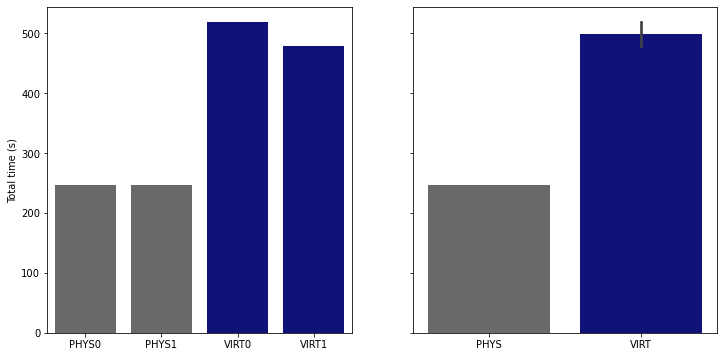

In [44]:
df_sf_b.sort_values('lbl', inplace=True)

fig, axes = plt.subplots(figsize=(12, 6), ncols=2, sharey=True)
# plot all the experiments
axe0 = sns.barplot(x='lbl', y='tot', palette=df_sf_b['color'], data=df_sf_b, ax=axes[0])
axe0.set_xlabel('')
axe0.set_ylabel('Total time (s)')

# plot the average
axe1 = sns.barplot(x='kind', y='tot', palette=df_sf_b['color'].unique(), ci='sd', data=df_sf_b, ax=axes[1])
axe1.set_xlabel(''); axe1.set_ylabel('');

In [45]:
mu, sig = df_sf.groupby('kind').mean(), df_sf.groupby('kind').std()
print (f"Physical: {mu.loc['PHYS'].item():.2f} +/- {sig.loc['PHYS'].item():.2f} seconds")
print (f"Virtual: {mu.loc['VIRT'].item():.2f} +/- {sig.loc['VIRT'].item():.2f} seconds")

Physical: 247.20 +/- 0.01 seconds
Virtual: 498.02 +/- 28.62 seconds


### Virtual vs Physical, all branch

In [48]:
df_sf1 = df_sf.copy()
df_sf1['gbranch'] = 'dev'
df_sf1['tot'] += 100
df_sf  = pd.concat([df_sf, df_sf1])

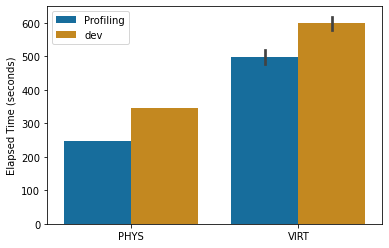

In [50]:
ax = sns.barplot(x='kind', y='tot', data=df_sf.sort_values('kind'), palette='colorblind', hue='gbranch')
ax.set_xlabel('')
ax.set_ylabel('Elapsed Time (seconds)')
ax.legend().set_title('')


In [74]:
mu, sig = df_sf.groupby('kind gbranch'.split()).mean().reset_index(), df_sf.groupby('kind gbranch'.split()).std().reset_index()
for gb in mu['gbranch'].unique():
    mu0, sig0 = mu[mu.gbranch == gb].set_index('kind'), sig[sig.gbranch==gb].set_index('kind')
    print (f"Physical {gb}: {mu0.loc['PHYS', 'tot'].item():.2f} +/- {sig0.loc['PHYS', 'tot'].item():.2f} seconds")
    print (f"Virtual {gb}: {mu0.loc['VIRT', 'tot'].item():.2f} +/- {sig0.loc['VIRT', 'tot'].item():.2f} seconds")
    print ('')

Physical Profiling: 247.20 +/- 0.01 seconds
Virtual Profiling: 498.02 +/- 28.62 seconds

Physical dev: 347.20 +/- 0.01 seconds
Virtual dev: 598.02 +/- 28.62 seconds

